In [1]:
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import shutil
from tensorflow.keras.applications.resnet50 import ResNet50,  preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import glob
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
from PIL import Image as PILImage
import clip
import torch  

2025-10-15 16:06:22.897087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/leonel/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def extract_frames(video_path, output_folder):
    
    if os.path.exists(output_folder):
        print(f"Removing existing folder: {output_folder}")
        shutil.rmtree(output_folder)
    
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    count = 0
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"FPS: {fps:.2f}")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(f"{output_folder}/{count:04d}.jpg", frame)
        count += 1
    cap.release()
    print(f"{count} frames extraites.")
    
video_path = 'corrupted_video.mp4'
extract_frames(video_path, 'frames')

Removing existing folder: frames
FPS: 25.00
301 frames extraites.


In [ ]:
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
paths = sorted(glob.glob("frames/*.jpg"))
device = "cpu"  # or "cuda" if available
#model, preprocess = clip.load("ViT-B/32", device=device)

CLEAN_DIR = "clean_frames"
REMOVED_DIR = "removed_frames"
EPS = 15
MIN_SAMPLES = 5
PCA_COMPONENTS = 0.95 


for folder in [CLEAN_DIR, REMOVED_DIR]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

def get_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).flatten()



def get_clip_features(img_path, model):
    img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img)
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

    return emb.cpu().numpy().flatten()

def clean_frames(paths, model, n_clusters=2):
    features = np.array([get_features(p, model) for p in paths])
    pca = PCA(n_components=PCA_COMPONENTS)
    features_reduced = pca.fit_transform(features)
    """
    # KMEANS
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_reduced)
    
    main_cluster = np.bincount(labels).argmax()
    clean_paths = [p for p, l in zip(paths, labels) if l == main_cluster]
    """

    db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='euclidean')
    labels = db.fit_predict(features_reduced)

    clean_paths = [p for p, l in zip(paths, labels) if l != -1]
    removed_paths = [p for p, l in zip(paths, labels) if l == -1]
    clean_indices = [i for i, l in enumerate(labels) if l != -1]
    for p in removed_paths:
        shutil.copy(p, os.path.join(REMOVED_DIR, os.path.basename(p)))
    pca = PCA(n_components=PCA_COMPONENTS)

    print(f"{len(clean_paths)} frames kept out of {len(paths)}")

    mask = labels != -1
    clean_embeddings = features[mask]
    clean_labels = labels[mask]

    return clean_paths, clean_embeddings, clean_labels, clean_indices


clean_paths, clean_features, labels, clean_indices = clean_frames(paths, model, n_clusters=2)

2025-10-15 16:06:35.801942: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [4]:
clean_features

array([[3.3588141e-02, 3.9412871e-01, 3.5005367e-01, ..., 2.2529259e-01,
        3.7891987e-01, 3.3155231e+00],
       [1.8798061e-01, 4.4122291e-01, 1.5518439e-01, ..., 6.0294449e-01,
        1.0489754e-01, 6.4971775e-01],
       [5.2944563e-02, 1.8745860e-01, 1.8060844e-01, ..., 6.1737698e-01,
        3.6078036e-01, 9.2278160e-02],
       ...,
       [1.7950866e-01, 7.6810509e-01, 2.2553986e-01, ..., 3.9812639e-01,
        1.7845644e-01, 3.8691700e+00],
       [5.0606430e-01, 1.7429705e+00, 1.4187620e-03, ..., 1.4368507e-01,
        7.0221359e-01, 4.2865169e-01],
       [8.9788568e-01, 8.6995369e-01, 2.3112440e-02, ..., 2.5260237e-01,
        1.6612516e-01, 3.5064521e-01]], shape=(257, 2048), dtype=float32)

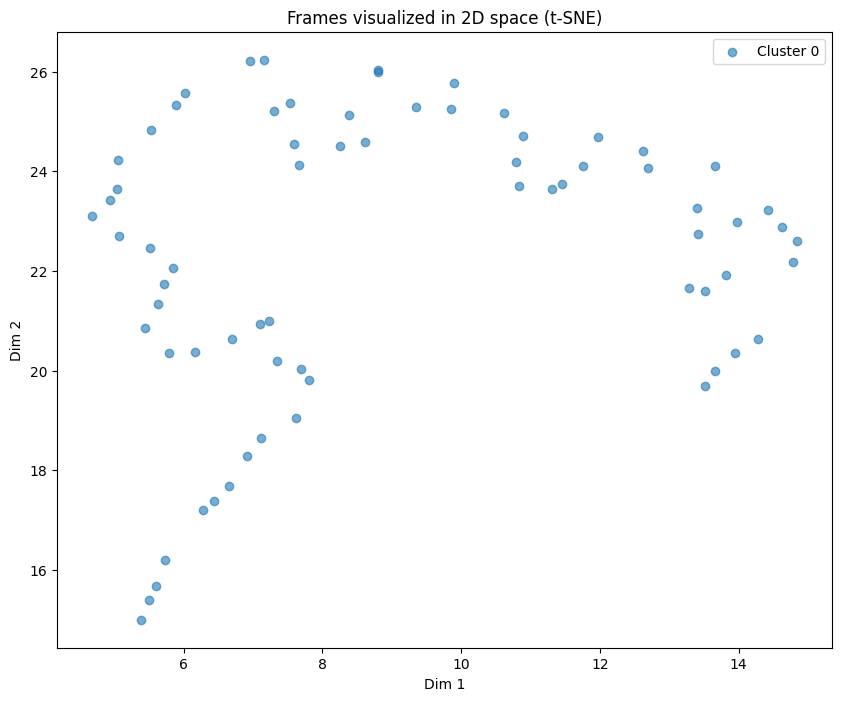

In [5]:
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(clean_features)

plt.figure(figsize=(10, 8))
for i in range(1):
    idx = labels == i
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Cluster {i}", alpha=0.6)
plt.legend()
plt.title("Frames visualized in 2D space (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

 Motion distance using optical flow does not provide better results

In [ ]:
pca = PCA(n_components=PCA_COMPONENTS)
clean_features = np.array([get_features(p, model) for p in clean_paths])
clean_features = pca.fit_transform(clean_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
def reorder_frames(frame_list):
    """
    The idea is to start from a random frame (0 for instance), then we look for the closest image to that starting image. 
    We keep adding images from the start of the ordered list or from the end till we finish adding all images. 
    A final step is now to find the real starting point of the video, to do so we look for the biggest different between to consecutive frames.
    """
    
    differences = distance.cdist(frame_list, frame_list, 'euclidean')

    ## First we order the frames 
    first_img = 0 # Random start
    ordered = [first_img]
    for _ in range( len(frame_list)-1):
      last_img = ordered[-1]
      arg_l = np.argsort(differences[last_img]) 
      # search for the closest img to the last one not in the ordered list
      i = 0
      while(arg_l[i] in ordered):
        i += 1
      to_add = arg_l[i]

      if len(ordered) > 1:
        first_img = ordered[0]
        arg_l_start = np.argsort(differences[first_img]) 
        # search for the closest img to the first one not in the ordered list
        i = 0
        while(arg_l_start[i] in ordered):
          i += 1
        to_add_begining = arg_l_start[i]
        
        # choose to add to the begining or to the end of the list
        if differences[first_img][to_add_begining] < differences[last_img][to_add]:
          ordered = [to_add_begining] + ordered
        else:
          ordered.append(to_add)
      else:
        ordered.append(to_add)

    ## find the real starting frame 
    idx_max_diff = 0
    max_diff = differences[len(differences)-1][ordered[0]]
    for i in range(len(ordered)-1):
      if differences[ordered[i]][ordered[i+1]] > max_diff:
        max_diff = differences[ordered[i]][ordered[i+1]]
        idx_max_diff = i+1

    real_start = idx_max_diff
    ordered = ordered[real_start:] + ordered[0:real_start]
    return ordered


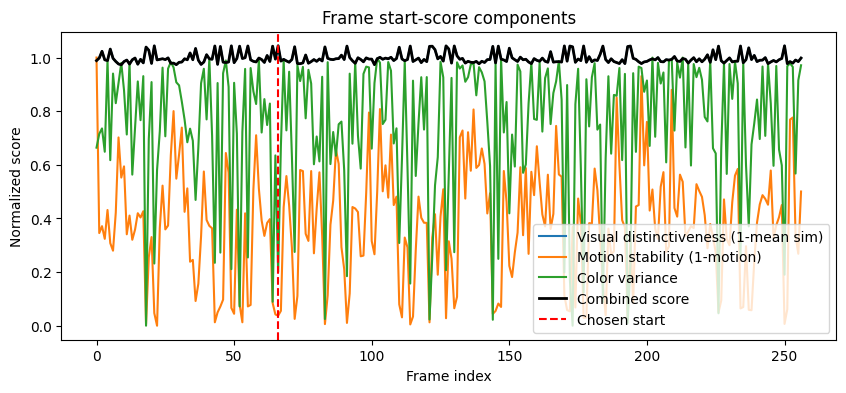

🟢 Best start frame index: 66
✅ TSP ordering done, 258 frames.


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
from networkx.algorithms import approximation as approx
from networkx.algorithms.approximation.traveling_salesman import simulated_annealing_tsp, christofides
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial import distance


def find_start_frame(features, frames, alpha=0.7, beta=0.3, gamma=0):
    """
    Find the most likely first frame using a combination of:
    - Visual distinctiveness (features)
    - Motion difference (pixel-level)
    - Color histogram variance
    """
    n = len(frames)
    
    S = cosine_similarity(features)
    visual_score = 1 - S.mean(axis=1)  # low mean similarity → more unique

 
    motion_score = np.zeros(n)
    for i in range(n - 1):
        diff = np.mean(np.abs(frames[i+1].astype(np.float32) - frames[i].astype(np.float32)))
        motion_score[i+1] = diff
    motion_score = (motion_score - motion_score.min()) / (motion_score.max() - motion_score.min() + 1e-8)


    color_score = np.zeros(n)
    for i, f in enumerate(frames):
        hist = cv2.calcHist([f], [0,1,2], None, [8,8,8], [0,256]*3)
        hist = cv2.normalize(hist, hist).flatten()
        color_score[i] = np.std(hist)
    color_score = (color_score - color_score.min()) / (color_score.max() - color_score.min() + 1e-8)


    start_score = alpha * visual_score + beta * (1 - motion_score )+ gamma * color_score
    start_frame_index = np.argmax(start_score)


    plt.figure(figsize=(10,4))
    plt.plot(visual_score, label='Visual distinctiveness (1-mean sim)')
    plt.plot(1 - motion_score, label='Motion stability (1-motion)')
    plt.plot(color_score, label='Color variance')
    plt.plot(start_score, label='Combined score', linewidth=2, color='k')
    plt.axvline(start_frame_index, color='r', linestyle='--', label='Chosen start')
    plt.legend()
    plt.title("Frame start-score components")
    plt.xlabel("Frame index")
    plt.ylabel("Normalized score")
    plt.show()

    print(f"🟢 Best start frame index: {start_frame_index}")
    return start_frame_index, start_score



def smooth_order(path, D, window=5):
    """
    Smooths a TSP-reordered path locally.
    
    Parameters:
        path (list of int): current frame order (indices)
        D (np.array): distance matrix (n x n)
        window (int): number of frames before/after to consider for local swaps
    Returns:
        smoothed path (list of int)
    """
    n = len(path)
    smoothed_path = path.copy()
    
    for i in range(n):
        # check window before and after
        start = max(0, i - window)
        end = min(n, i + window + 1)
        
        segment = smoothed_path[start:end]
        improved = True
        
        # Keep trying swaps until no improvement
        while improved:
            improved = False
            for j in range(len(segment)-1):
                # distance before swap
                dist_orig = D[segment[j], segment[j+1]]
                
                # distance after swap
                segment[j], segment[j+1] = segment[j+1], segment[j]
                dist_new = D[segment[j], segment[j+1]]
                
                if dist_new < dist_orig:
                    improved = True
                else:
                    # swap back if no improvement
                    segment[j], segment[j+1] = segment[j+1], segment[j]
        
        # update smoothed path
        smoothed_path[start:end] = segment
    
    return smoothed_path


def motion_diff(f1, f2):
    """Compute mean absolute difference between two frames."""
    return np.mean(np.abs(f1.astype(np.float32) - f2.astype(np.float32)))
    
def motion_finetune(path, frames, window=5):
    """
    Motion-based local refinement for frame order.
    Tries local swaps within a window to minimize sudden motion jumps
    (difference between consecutive frames).

    Parameters:
        path (list of int): current frame order (indices)
        frames (list of np.array): preloaded frames (same order as indices)
        window (int): number of neighbors before/after to consider for local swaps

    Returns:
        refined_path (list of int): motion-smoothed order
    """
    n = len(path)
    refined_path = path.copy()

    for i in range(n):
        start = max(0, i - window)
        end = min(n, i + window + 1)
        segment = refined_path[start:end]
        improved = True

        while improved:
            improved = False
            for j in range(len(segment) - 1):
                f1a = frames[segment[j]]
                f2a = frames[segment[j + 1]]
                dist_orig = motion_diff(f1a, f2a)

                # try swapping
                segment[j], segment[j + 1] = segment[j + 1], segment[j]
                f1b = frames[segment[j]]
                f2b = frames[segment[j + 1]]
                dist_new = motion_diff(f1b, f2b)

                if dist_new < dist_orig:
                    improved = True
                else:
                    # revert if not better
                    segment[j], segment[j + 1] = segment[j + 1], segment[j]

        refined_path[start:end] = segment

    return refined_path



def reconstruct_order(clean_paths, clean_features, w_feat=1, w_motion=0, w_color=0, smoothing = True):

    frames = [cv2.imread(p) for p in clean_paths]
    start_frame_index, scores = find_start_frame(clean_features, frames, alpha=w_feat, beta=w_motion)

    n = len(clean_paths)
    
    D_feat = 1 - cosine_similarity(clean_features)

    D_motion = np.zeros((n, n))
    if w_motion > 0:
        for i in range(n):
            for j in range(i+1, n):
                D_motion[i,j] = np.mean(np.abs(frames[i].astype(float) - frames[j].astype(float)))
                D_motion[j,i] = D_motion[i,j]

    D_feat = np.nan_to_num(D_feat, nan=0.0, posinf=0.0, neginf=0.0)
    D_motion = np.nan_to_num(D_motion, nan=0.0, posinf=0.0, neginf=0.0)

    D_feat /= D_feat.max() 
    max_val = D_motion.max()
    if max_val > 0:
        D_motion /= max_val

    max_val = D_feat.max()
    if max_val > 0:
        D_feat /= max_val

    D = w_feat*D_feat + w_motion*D_motion

    G = nx.complete_graph(n)
    for i in range(n):
        for j in range(i+1, n):
            G[i][j]['weight'] = D[i, j]
    

    path = approx.greedy_tsp(G, source=start_frame_index, weight='weight')
    #path = simulated_annealing_tsp(G,source=start_frame_index, init_cycle=path, weight='weight')
    #path = reorder_frames(clean_features)

    if smoothing:
        path = smooth_order(path, D, window=15)
        path = motion_finetune(path, frames, window=15)
    ordered_paths = [clean_paths[i] for i in path]
    print(f"✅ TSP ordering done, {len(path)} frames.")
    return ordered_paths

ORDER_DIR = "ordered_frames"
for folder in [ORDER_DIR]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

ordered_paths = reconstruct_order(clean_paths, clean_features, smoothing = True)


In [51]:
def make_video(image_paths, output_path, fps=25):
    frame = cv2.imread(image_paths[0])
    h, w, _ = frame.shape
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    for img_path in image_paths:
        out.write(cv2.imread(img_path))
    out.release()

    reversed_path = output_path.replace(".mp4", "_reversed.mp4")
    out_rev = cv2.VideoWriter(reversed_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    for img_path in image_paths[::-1]:
        frame = cv2.imread(img_path)
        out_rev.write(frame)
    out_rev.release()


make_video(ordered_paths, output_path="reconstructed_video.mp4", fps=25)

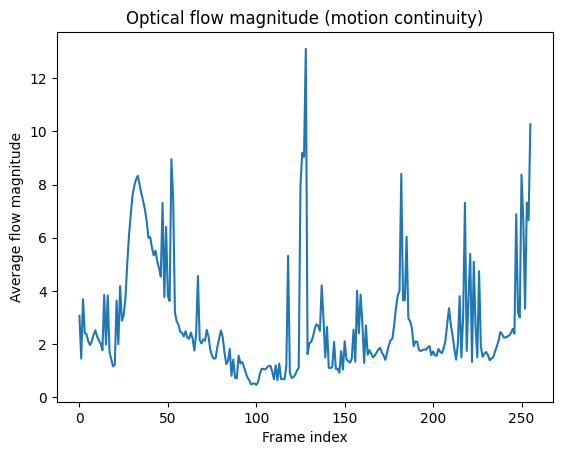

[np.float32(3.0631454),
 np.float32(1.4583273),
 np.float32(3.6902492),
 np.float32(2.417738),
 np.float32(2.373296),
 np.float32(2.10372),
 np.float32(1.9687163),
 np.float32(2.1228247),
 np.float32(2.3554573),
 np.float32(2.5252912),
 np.float32(2.2911303),
 np.float32(2.1359038),
 np.float32(2.0212045),
 np.float32(1.7761809),
 np.float32(3.84749),
 np.float32(1.9865252),
 np.float32(3.8339577),
 np.float32(1.7097939),
 np.float32(1.4280647),
 np.float32(1.1659528),
 np.float32(1.2393104),
 np.float32(3.6369216),
 np.float32(1.9998974),
 np.float32(4.182629),
 np.float32(2.87943),
 np.float32(3.0872743),
 np.float32(3.7255843),
 np.float32(4.9932857),
 np.float32(6.073136),
 np.float32(6.879457),
 np.float32(7.5806518),
 np.float32(7.945519),
 np.float32(8.187171),
 np.float32(8.3289385),
 np.float32(7.99972),
 np.float32(7.6648707),
 np.float32(7.3861847),
 np.float32(7.074705),
 np.float32(6.633862),
 np.float32(5.999422),
 np.float32(6.0285535),
 np.float32(5.6306157),
 np.float3

In [9]:
def check_continuity_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev = cap.read()
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    mags = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
        mags.append(np.mean(mag))
        prev_gray = gray
    cap.release()

    plt.plot(mags)
    plt.title("Optical flow magnitude (motion continuity)")
    plt.xlabel("Frame index")
    plt.ylabel("Average flow magnitude")
    plt.show()

    return mags

check_continuity_flow("/home/leonel/INA/reconstructed_video.mp4")

In [ ]:
frame_paths = sorted(glob.glob("ordered_frames/*.jpg"))  

frames = [PILImage.open(p) for p in frame_paths]
frames = [f.resize((320, 180)) for f in frames] 

gif_path = "temp_animation.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=80,  #ms
    loop=0
)
display(Image(filename=gif_path))

IndexError: list index out of range

## The results with this simple approach are not good! Let's try a different one.